/home/yagomcastro/miniforge3/envs/latinmag/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yagomcastro/miniforge3/envs/latinmag/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yagomcastro/miniforge3/envs/latinmag/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yagomcastro/miniforge3/envs/latinmag/lib/python3.9/site

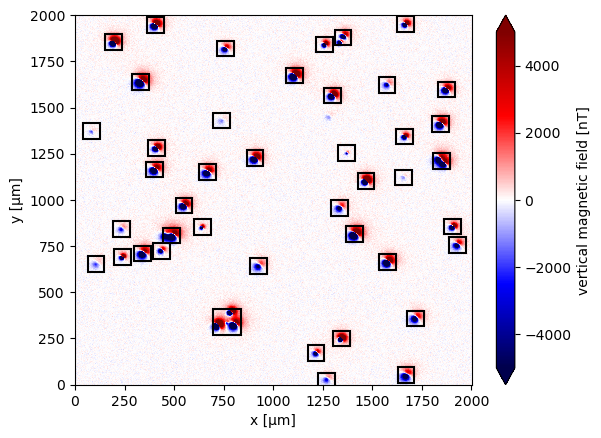

In [1]:
import numpy as np
import verde as vd
import magali as mg
import harmonica as hm
import skimage.exposure
import xarray as xr
import matplotlib.pyplot as plt
from magali._utils import total_gradient_amplitude_grid

SEED = 5
rng = np.random.default_rng(SEED)

sensor_sample_distance = 5.0  # µm
region = [0, 2000, 0, 2000]  # µm
spacing = 2  # µm

true_inclination = 30  # degrees
true_declination = 40  # degrees
true_dispersion_angle = 5  # degrees
size = 50  # number of random dipoles

directions_inclination, directions_declination = mg.random_directions(
    true_inclination,
    true_declination,
    true_dispersion_angle,
    size=size,
    random_state= SEED,
)

dipoles_amplitude = abs(rng.normal(0, 100, size)) * 1.0e-14

dipole_coordinates = (
    rng.integers(30, 1970, size), # x
    rng.integers(30, 1970, size), # y
    rng.integers(-20, -1, size), # z
)

dipole_moments = hm.magnetic_angles_to_vec(
    inclination=directions_inclination,
    declination=directions_declination,
    intensity=dipoles_amplitude,
)

data = mg.dipole_bz_grid(
    region, spacing, sensor_sample_distance,
    dipole_coordinates, dipole_moments
)

noise_std_dev = 100  # nT
noise = rng.normal(loc=0, scale=noise_std_dev, size=data.shape)
data.values += noise

height_difference = 5 #µm

data_up = (
    hm.upward_continuation(data, height_difference)
    .assign_attrs(data.attrs)
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
    .rename("bz")
)

dx, dy, dz, tga = mg.gradient(data_up)
data_up["dx"] = dx
data_up["dy"] = dy
data_up["dz"] = dz
data_up["tga"] = tga

stretched = skimage.exposure.rescale_intensity(
    tga,
    in_range=tuple(np.percentile(tga, (1, 99))),
)
data_tga_stretched = xr.DataArray(stretched, coords=data_up.coords)

windows = mg.detect_anomalies(
    data_tga_stretched,
    size_range = [30, 50], #µm
    detection_threshold = 0.03,
    border_exclusion= 2,
    size_multiplier = 1,
)

locations_ = []
dipole_moments_ = []
r2_ = []

data_copy = data.copy(deep=True)
data_up_copy = data_up.copy(deep=True)
for window in windows:
    anomaly = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    dx, dy, dz, tga = mg.gradient(anomaly)
    table = vd.grid_to_table(anomaly)

    euler = hm.EulerDeconvolution(3)
    euler.fit(
        (table.x, table.y, table.z),
        (table.bz, table.dx, table.dy, table.dz)
    )

    bz_corrected = table.bz.values - euler.base_level_

    coordinates = (table.x.values, table.y.values, table.z.values)

    model_nl = mg.NonlinearMagneticDipoleBz(initial_location=euler.location_)
    model_nl.fit(coordinates, bz_corrected)
    locations_.append(model_nl.location_)
    dipole_moments_.append(model_nl.dipole_moment_)
    r2_.append(model_nl.r2_)

    discard = mg.dipole_bz(coordinates, model_nl.location_, model_nl.dipole_moment_)
    
    for x_val, y_val, bz_val in zip(table.x.values, table.y.values, discard):
        data_up_copy.loc[dict(x=x_val, y=y_val)] -= bz_val

    data_up_copy = (
        hm.upward_continuation(data_up_copy, height_difference)
        .assign_attrs(data_up_copy.attrs)
        .assign_coords(x=data_up_copy.x, y=data_up_copy.y)
        .assign_coords(z=data_up_copy.z + height_difference)
        .rename("bz")
    )
    dx, dy, dz, tga = mg.gradient(data_up_copy)
    data_up_copy["dx"] = dx
    data_up_copy["dy"] = dy
    data_up_copy["dz"] = dz
    data_up_copy["tga"] = tga



fig, ax = plt.subplots()
data.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-5000, vmax=5000)
mg.plot_bounding_boxes(windows, ax=ax, color="black", linewidth=1.5)

plt.show()

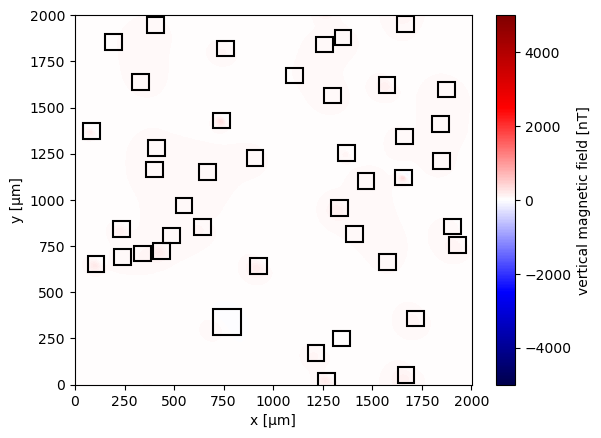

In [2]:
fig, ax = plt.subplots()
data_up_copy.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-5000, vmax=5000)
mg.plot_bounding_boxes(windows, ax=ax, color="black", linewidth=1.5)

plt.show()

/home/yagomcastro/miniforge3/envs/latinmag/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yagomcastro/miniforge3/envs/latinmag/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yagomcastro/miniforge3/envs/latinmag/lib/python3.9/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yagomcastro/miniforge3/envs/latinmag/lib/python3.9/site

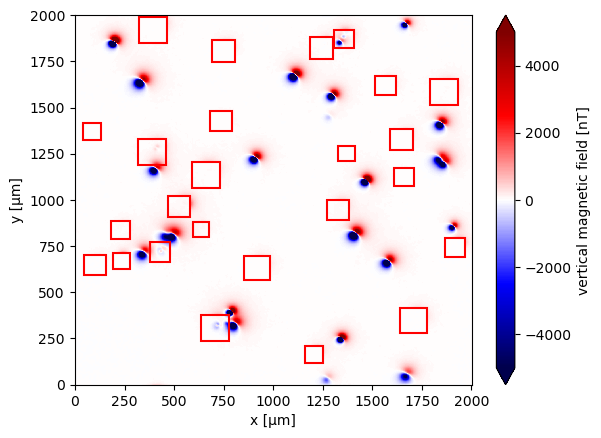

In [3]:
stretched = skimage.exposure.rescale_intensity(
    data_up_copy.tga,
    in_range=tuple(np.percentile(data_up_copy.tga, (1, 99))),
)
data_tga_stretched = xr.DataArray(stretched, coords=data_up.coords)

new_windows = mg.detect_anomalies(
    data_tga_stretched,
    size_range = [30, 50], #µm
    detection_threshold = 0.03,
    border_exclusion= 2,
    size_multiplier = 1,
)


new_locations_ = []
new_dipole_moments_ = []
r2_ = []

data_copy = data.copy(deep=True)
data_up_copy = data_up.copy(deep=True)
for window in new_windows:
    anomaly = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    dx, dy, dz, tga = mg.gradient(anomaly)
    table = vd.grid_to_table(anomaly)

    euler = hm.EulerDeconvolution(3)
    euler.fit(
        (table.x, table.y, table.z),
        (table.bz, table.dx, table.dy, table.dz)
    )

    bz_corrected = table.bz.values - euler.base_level_

    coordinates = (table.x.values, table.y.values, table.z.values)

    model_nl = mg.NonlinearMagneticDipoleBz(initial_location=euler.location_)
    model_nl.fit(coordinates, bz_corrected)
    new_locations_.append(model_nl.location_)
    new_dipole_moments_.append(model_nl.dipole_moment_)
    r2_.append(model_nl.r2_)

    discard = mg.dipole_bz(coordinates, model_nl.location_, model_nl.dipole_moment_)
    
    for x_val, y_val, bz_val in zip(table.x.values, table.y.values, discard):
        data_up_copy.loc[dict(x=x_val, y=y_val)] -= bz_val

    # data_up_copy = (
    #     hm.upward_continuation(data_up_copy, height_difference)
    #     .assign_attrs(data_up_copy.attrs)
    #     .assign_coords(x=data_up_copy.x, y=data_up_copy.y)
    #     .assign_coords(z=data_up_copy.z + height_difference)
    #     .rename("bz")
    # )
    dx, dy, dz, tga = mg.gradient(data_up_copy)
    data_up_copy["dx"] = dx
    data_up_copy["dy"] = dy
    data_up_copy["dz"] = dz
    data_up_copy["tga"] = tga



fig, ax = plt.subplots()
data_up_copy.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-5000, vmax=5000)
mg.plot_bounding_boxes(new_windows, ax=ax, color="red", linewidth=1.5)

plt.show()

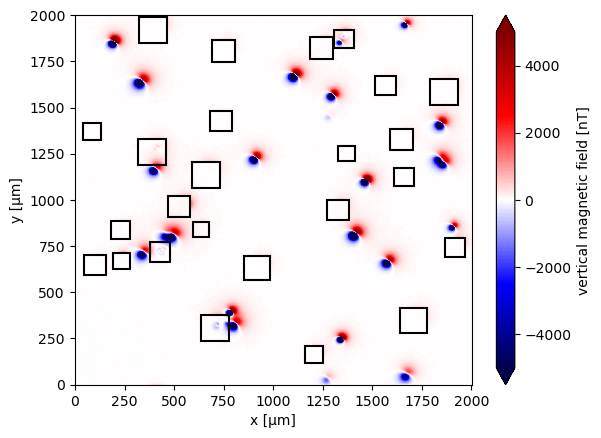

In [4]:
fig, ax = plt.subplots()
data_up_copy.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-5000, vmax=5000)
mg.plot_bounding_boxes(new_windows, ax=ax, color="black", linewidth=1.5)

plt.show()

In [5]:
new_locations_

[array([1659.74983651, 1123.83550914,  -11.34467843]),
 array([ 743.16016219, 1432.68081584,  -18.16745259]),
 array([  86.08340724, 1372.8567546 ,   -9.93051856]),
 array([109.24627136, 655.98151889, -19.84769377]),
 array([929.00624846, 644.96857107, -18.99571726]),
 array([435.92238916, 726.57762992,  -7.70544457]),
 array([237.1057683 , 844.70406361, -13.96165354]),
 array([1576.97701832, 1626.92541883,  -13.96555852]),
 array([1371.95282238, 1253.85232319,   -2.96643298]),
 array([1337.9602963 ,  959.79892705,  -15.08197547]),
 array([1931.02879644,  759.05092521,  -13.88000641]),
 array([1218.03170825,  172.00760298,   -9.0136604 ]),
 array([ 760.03094455, 1820.99207826,  -11.01297878]),
 array([640.91921036, 851.99311886,  -1.988181  ]),
 array([1719.97002338,  361.01235931,  -16.96937628]),
 array([719.92310284, 321.12829731,  -5.72704776]),
 array([1261.95653216, 1843.00576209,   -3.95620657]),
 array([1665.00526053, 1343.99649351,   -5.01528129]),
 array([1874.0049218 , 1598.

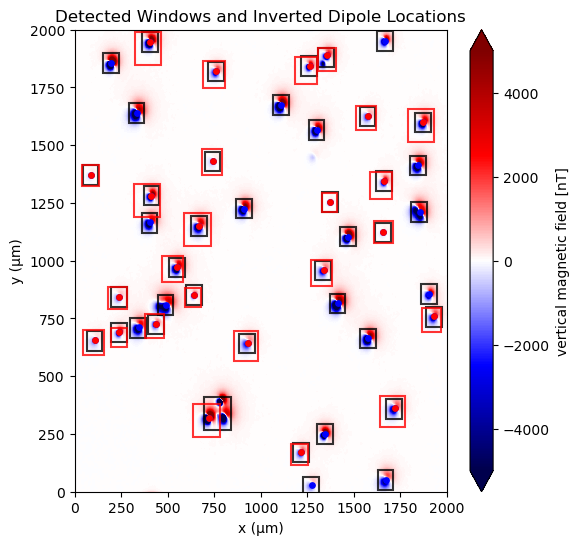

In [6]:
fig, ax = plt.subplots(figsize=(6, 6))
data_up.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-5000, vmax=5000)

mg.plot_bounding_boxes(windows, ax=ax, color="black", linewidth=1.5, alpha=0.8)
mg.plot_bounding_boxes(new_windows, ax=ax, color="red", linewidth=1.5, alpha=0.8)


if len(locations_) > 0:
    locations_arr = np.array(locations_)
    ax.scatter(
        locations_arr[:, 0],  # x
        locations_arr[:, 1],  # y
        c="blue",
        marker=".",
        s=60,
        label="Inverted dipoles (original)"
    )

if len(new_locations_) > 0:
    new_locations_arr = np.array(new_locations_)
    ax.scatter(
        new_locations_arr[:, 0],  # x
        new_locations_arr[:, 1],  # y
        c="red",
        marker=".",
        s=60,
        label="Inverted dipoles (new)"
    )

# ax.set_aspect("equal")
ax.set_xlim(region[0], region[1])
ax.set_ylim(region[2], region[3])
ax.set_xlabel("x (µm)")
ax.set_ylabel("y (µm)")
# ax.legend()
ax.set_title("Detected Windows and Inverted Dipole Locations")

plt.show()
